# Analysis of LiF diffraction

This it the primary file for the analysis of LiF (Lithium Floride) diffraction spot profiles taken on the Cambridge A-SHeH using the `SpotProfile` module.

In [2]:
# Some modules to use
import numpy as np
from shem_spot_profile import SpotProfile
import shem_spot_profile as ssp
from matplotlib import cm # 3D surface color
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Experimental data plot

The experimental data is taken as a series of z scans in files of the form `Z000xxx.mat`, a list of these is needed as well as a list of the azimuthal crystal orientation $\alpha$.

During the import the initial temperature of the beam and the azimuthal angle corresponding to a principle crystal azimuth needs to be specified.

In [3]:
file_ind = np.arange(418, 569, 1)
alphas = np.arange(0, 375.1, 2.5)

T = 298 # K
alpha_zero = 252 # degrees
scan360 = SpotProfile.import_ashem(file_ind, '../2020_11_LiF_v2', alphas, T=T, alpha_zero=alpha_zero)

The raw data is plotted as a function of $(z,\alpha)$. This form is useful for inspecting the whole dataset.

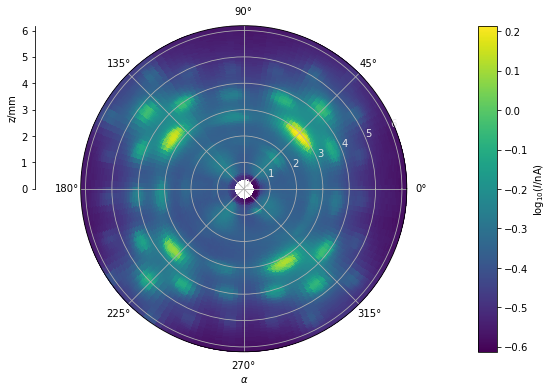

In [8]:
_ = scan360.shem_raw_plot()

Convert the $z$ position to the parallel momentum transfer, with $z$ in mm the polar detection angle is:
$$\theta = \arctan\left( \frac{7 - (z + 1.5)}{z + 1.5} \right)$$
then the momentum transfer is
$$\Delta K = K(\sin\theta - \sin\theta_i)=K\left(\sin\theta - \frac{1}{\sqrt{2}}\right)$$
for an incidnece angle of $45^\circ$.

Then we may plot as a function of $(\Delta K, \alpha)$.

/home/sam/LiF_2D_plots/SHeM_anysis_for_diffraction/shem_spot_profile.py:220: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh1 = ax1.pcolormesh(sP.alpha*np.pi/180, -sP.DK, np.log10(sP.signal),


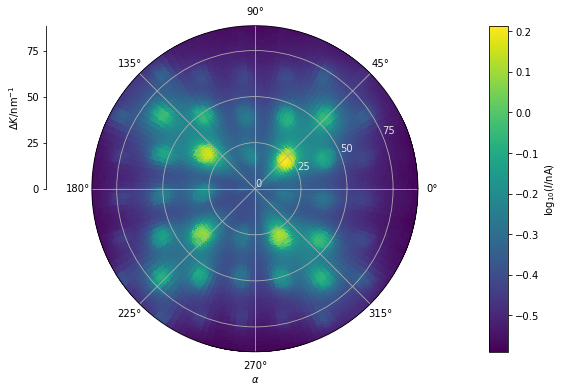

In [9]:
_ = scan360.shem_diffraction_plot()
plt.savefig('output_figures/K-alpha-plot.pdf')

## Simulated data plot

There are two sets of simulated data, one is assuming perfect aligment of the sample, the second uses an approximate value of the misaligment of the sample.

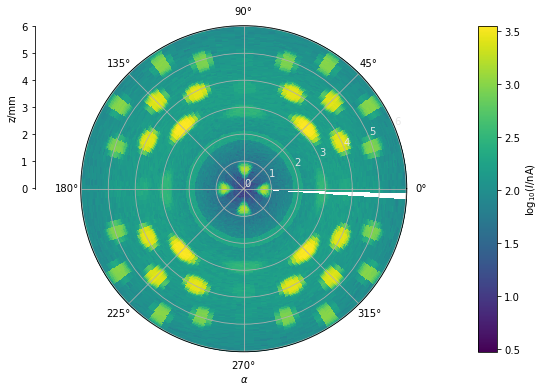

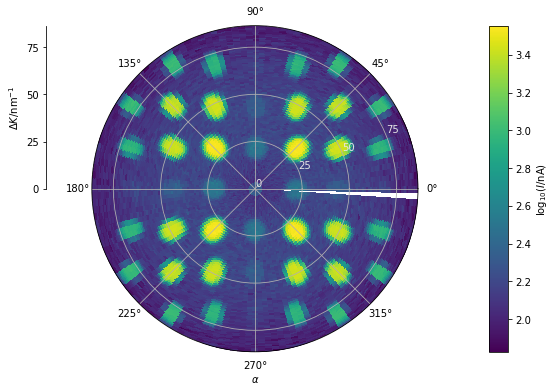

In [11]:
# Simulated 'ideal data'
idealSim = SpotProfile.import_ray('../0273_LiF_hiRes/')
idealSim.shem_raw_plot()
idealSim.shem_diffraction_plot()
plt.savefig('output_figures/K-alpha-simulated-ideal.pdf')

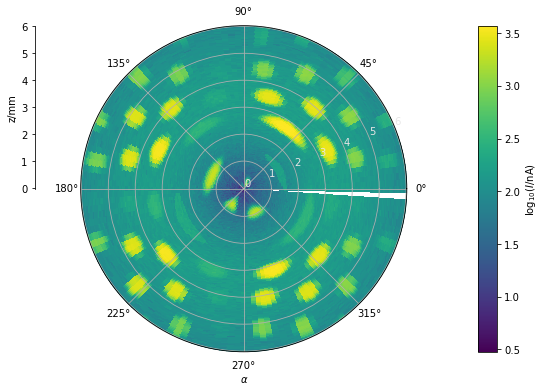

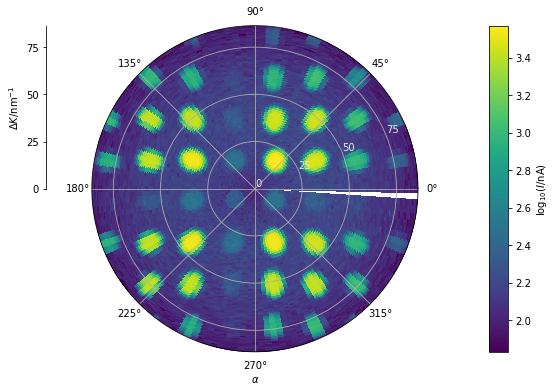

In [12]:
# Simulated data including sample tilt
tiltSim = SpotProfile.import_ray('../0275_LiF_tilt_hiRes/')
tiltSim.shem_raw_plot()
tiltSim.shem_diffraction_plot()
plt.savefig('output_figures/K-alpha-simulated-tilt.pdf')

## Identifying diffraction peaks

We identify the locations of diffraction peaks by fitting 2D Gaussian functions to the peaks.

To perform the fitting and identification we need to project onto a Cartesian grid, I interpolate the data in order to do that. By default I am using the method 'nearest' where the value of a pixel is just the value of the nearest data point. 

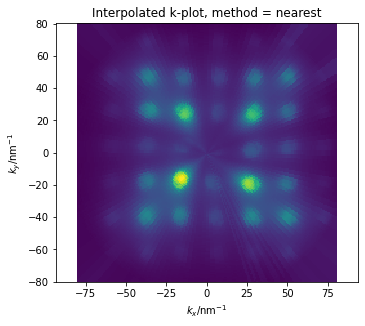

In [16]:
# Produce a filtered version of the data tha does not include data 'before specular'
scan360F = scan360.filter_by_var('z', 2)
_ = scan360F.interpolated_plot(N = 201, method = 'nearest')

### Example fit

This is an example of one fit to a single diffraction peak.

Text(0.5, 1.0, 'Fitted Gaussian')

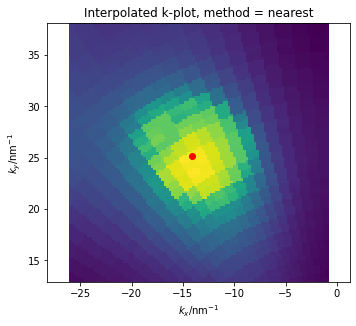

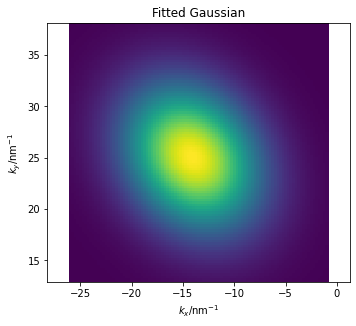

In [22]:
# Identify a single diffraction peak, then try to fit a gaussian to it
[f_interp, ax_interp] = scan360F.interpolated_plot(kx = (-26, -1), ky = (13, 38), N = 101, method = 'nearest')
I, kxx, kyy = scan360F.grid_interpolate(kx = (-26, -1), ky = (13, 38), N=101, method='nearest')

# Try to fit a 2D gaussian to the diffraction peak
initial_guess = (0.9,-12,25,3,3,45*np.pi/180,0.4)
popt, pcov = opt.curve_fit(ssp.twoD_Gaussian, (kxx, kyy), I.flatten(), p0=initial_guess)

# Add the identified centre to the plot of the raw data
ax_interp.plot(popt[1], popt[2], 'ro')

# Plot the fitted Gaussian (does it look decent at all?)
Gau = ssp.twoD_Gaussian((kxx, kyy), *popt)
f = plt.figure()
ax = f.add_axes([0.15, 0.1, 0.7, 0.9])
ax.pcolormesh(kxx, kyy, Gau.reshape(101, 101), edgecolors='face')
ax.axis('equal')
ax.set_xlabel('$k_x/\mathrm{nm}^{-1}$')
ax.set_ylabel('$k_y/\mathrm{nm}^{-1}$')
ax.set_title('Fitted Gaussian')

### Fit to every peak

Starting from peak locations picked out by eye split up the plot then fit Gaussians to each one, this then gives a list of peak locations in $(k_x, k_y)$ space.

In [ ]:
# TODO